In [143]:
import pandas as pd
import numpy as np
import pyarrow
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from scipy.stats import zscore

In [118]:
train=pd.read_parquet("/Users/Anna/Documents/Python/Supervise_data_challenge/train.parquet")
test=pd.read_parquet("/Users/Anna/Documents/Python/Supervise_data_challenge/test.parquet")
train=train.drop(['VendorID', 'store_and_fwd_flag'], axis=1)

On commence par nettoyer les donnees d'entrainement pour qu'elles soient tractables par nos algorithmes. 

On note que le pourboire doit toujours etre positif, donc on utilisera une fonction lambda pour ajuster les predictions obtenues pour qu'elles soient positives. 

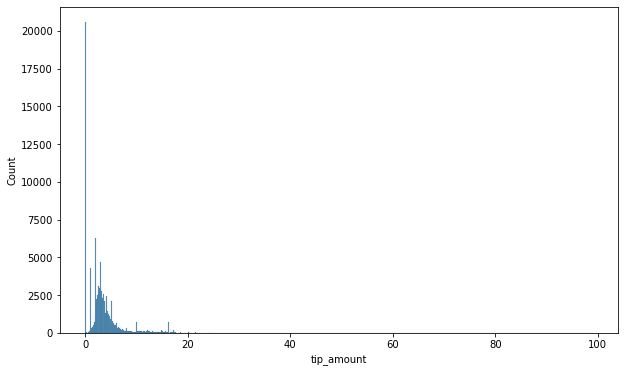

In [119]:
plt.figure(figsize=(10, 6))
sns.histplot(train['tip_amount'] )
plt.show()

In [120]:
train.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
0,2024-01-15 20:37:28,2024-01-15 20:56:43,1.0,3.30,1.0,1,19.1,3.5,0.5,4.80,0.0,1.0,2.5,0.0,40.734576,-74.002875,40.768615,-73.965635
1,2024-01-25 19:41:24,2024-01-25 19:44:42,1.0,0.72,1.0,1,5.8,2.5,0.5,2.46,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.780436,-73.957012
2,2024-01-25 15:48:48,2024-01-25 16:24:23,2.0,7.45,1.0,1,38.7,0.0,0.5,3.00,0.0,1.0,2.5,0.0,40.717773,-74.007880,40.780436,-73.957012
3,2024-01-27 00:47:26,2024-01-27 00:55:55,1.0,1.53,1.0,1,10.0,1.0,0.5,2.25,0.0,1.0,2.5,0.0,40.720889,-73.996919,40.747746,-73.978492
4,2024-01-28 13:14:26,2024-01-28 13:22:34,1.0,1.53,1.0,1,10.0,0.0,0.5,3.50,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.747746,-73.978492


In [121]:
train=train.dropna()

In [122]:
train.isnull().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
congestion_surcharge     0
Airport_fee              0
PU_location_lat          0
PU_location_lon          0
DO_location_lat          0
DO_location_lon          0
dtype: int64

On verifie que certaines colonnes ne sont pas inutiles

In [123]:
train['improvement_surcharge'].value_counts()

1.0    99984
0.3       14
0.0        2
Name: improvement_surcharge, dtype: int64

In [124]:
train['mta_tax'].value_counts()

0.5    99463
0.0      537
Name: mta_tax, dtype: int64

In [125]:
train['congestion_surcharge'].value_counts()

2.5    93405
0.0     6595
Name: congestion_surcharge, dtype: int64

In [126]:
train.describe()

,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.335090,3.213008,1.998210,1.186610,18.044265,1.538507,0.497315,3.430985,0.525877,0.999882,2.335125,0.140857,40.752187,-73.965628,40.754760,-73.971940
std,0.847745,4.219928,9.594546,0.458398,15.839824,1.788004,0.036542,3.686474,2.020583,0.009412,0.620490,0.476090,0.032148,0.048564,0.031182,0.036295
min,0.000000,0.010000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.576961,-74.174002,40.528686,-74.187679
25%,1.000000,1.000000,1.000000,1.000000,8.600000,0.000000,0.500000,1.000000,0.000000,1.000000,2.500000,0.000000,40.740439,-73.989845,40.740337,-73.989845
50%,1.000000,1.690000,1.000000,1.000000,12.800000,1.000000,0.500000,2.800000,0.000000,1.000000,2.500000,0.000000,40.758028,-73.977698,40.758028,-73.977698
75%,1.000000,3.100000,1.000000,1.000000,19.800000,2.500000,0.500000,4.200000,0.000000,1.000000,2.500000,0.000000,40.773633,-73.965146,40.773633,-73.961764
max,7.000000,53.640000,99.000000,4.000000,214.800000,11.750000,0.500000,99.000000,49.260000,1.000000,2.500000,1.750000,40.899528,-73.726655,40.899528,-73.711025


 On adapte les donnees de date en donnees tractables et on identifie les outliers

In [150]:
t2=train.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)
t2['elapsed_time']=(train['tpep_dropoff_datetime']-train['tpep_pickup_datetime']).dt.total_seconds() / 60
t2['pickup_month'] = train['tpep_pickup_datetime'].dt.month
t2['pickup_day'] = train['tpep_pickup_datetime'].dt.day
t2['pickup_hour'] = train['tpep_pickup_datetime'].dt.hour

Quasiment toutes les courses ont ete faites en janvier: on peut supprimer la colonne des mois

In [151]:
t2['pickup_month'].value_counts()

1     99999
12        1
Name: pickup_month, dtype: int64

In [152]:
t2=t2.drop(['pickup_month'], axis=1)

On regarde les boxplot des variables pour identifier les outliers avant de regarder les graphes des variables

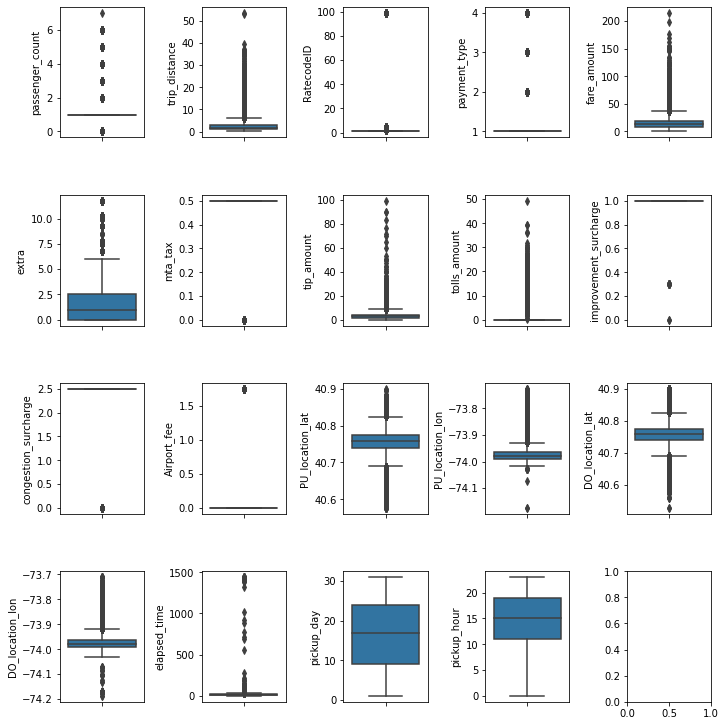

In [153]:
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(10, 10))
index = 0
axs = axs.flatten()

for k in t2.columns:
    sns.boxplot(y=k, data=t2, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

On remplace les outliers

In [155]:
z_scores = np.abs(zscore(t2))
threshold = 2
outliers = (z_scores > threshold)
t2_cleaned = t2.apply(lambda col: col.where(np.abs(zscore(col)) <= threshold, col.median()), axis=0)


In [156]:
t2_cleaned

,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon,elapsed_time,pickup_day,pickup_hour
0,1.0,3.30,1.0,1.0,19.1,3.5,0.5,4.80,0.0,1.0,2.5,0.0,40.734576,-74.002875,40.768615,-73.965635,19.250000,15,20.0
1,1.0,0.72,1.0,1.0,5.8,2.5,0.5,2.46,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.780436,-73.957012,3.300000,25,19.0
2,2.0,7.45,1.0,1.0,38.7,0.0,0.5,3.00,0.0,1.0,2.5,0.0,40.717773,-74.007880,40.780436,-73.957012,35.583333,25,15.0
3,1.0,1.53,1.0,1.0,10.0,1.0,0.5,2.25,0.0,1.0,2.5,0.0,40.720889,-73.996919,40.747746,-73.978492,8.483333,27,15.0
4,1.0,1.53,1.0,1.0,10.0,0.0,0.5,3.50,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.747746,-73.978492,8.133333,28,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.0,4.38,1.0,1.0,26.1,0.0,0.5,3.00,0.0,1.0,2.5,0.0,40.768615,-73.965635,40.718938,-73.990896,25.916667,19,9.0
99996,1.0,5.34,1.0,1.0,25.4,1.0,0.5,6.08,0.0,1.0,2.5,0.0,40.748497,-73.992438,40.706808,-74.007496,17.550000,25,15.0
99997,1.0,10.10,1.0,1.0,35.5,0.0,0.5,0.00,0.0,1.0,2.5,0.0,40.758028,-73.885867,40.773633,-73.981532,34.483333,8,9.0
99998,1.0,5.82,1.0,2.0,36.6,0.0,0.5,0.00,0.0,1.0,2.5,0.0,40.780436,-73.957012,40.777427,-73.905407,41.133333,6,18.0


On regarde maintenant les graphes des variables 

/Users/Anna/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Anna/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Anna/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

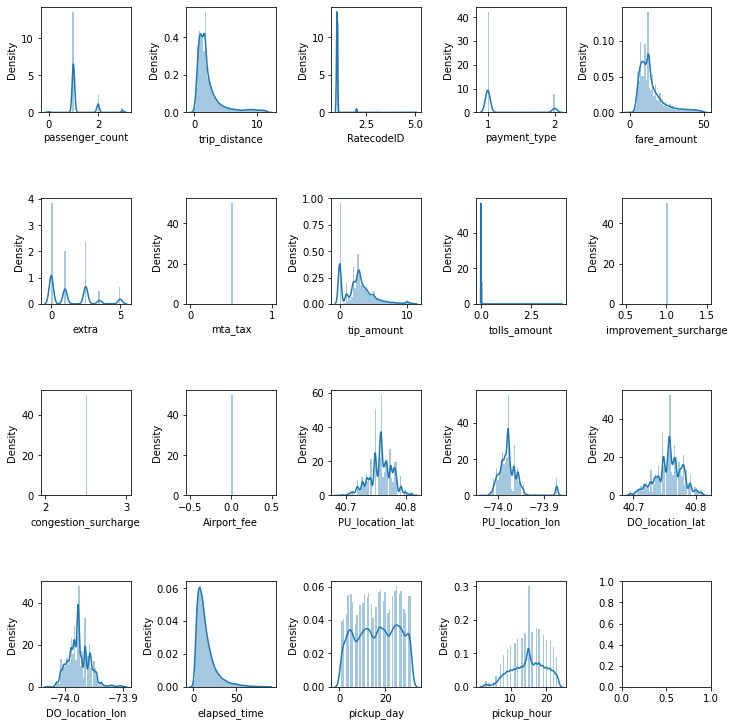

In [157]:
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(10, 10))
index = 0
axs = axs.flatten()
for k in t2_cleaned.columns:
    sns.distplot(t2_cleaned[k], ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Enfin, on regarde la matrice de correlations des donnees

<AxesSubplot:>

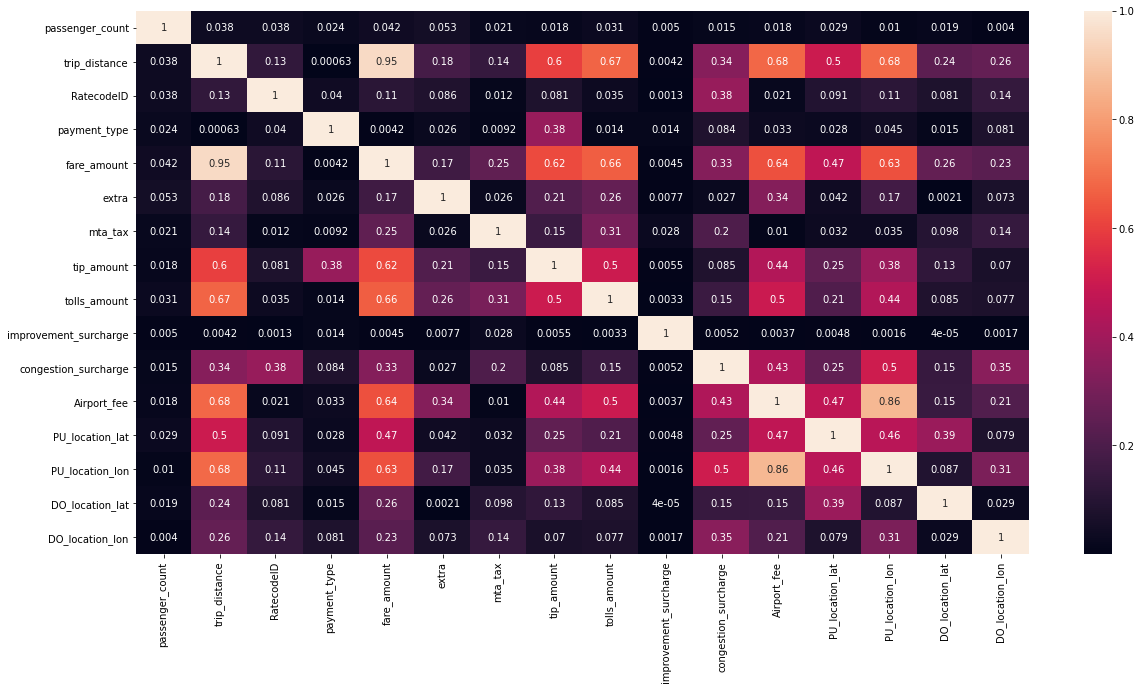

In [134]:
plt.figure(figsize=(20, 10))
sns.heatmap(train.corr().abs(),  annot=True)

On voit que le prix de la course et la distance de la course sont tres fortement correllees. De plus, la prime d'aeroport est fortement correllee a l'information de longitude de pickup, qui correspond a la position de l'aeroport. Ce qui est surprenant est qu'elle n'est pas correllee a la longitude de dropoff, donc la prime d'aeroport n'est peut etre appliquee qu'aux arrivants. Enfin, le montant du pourboire est assez correllee a la distance et au prix de la course.

On supprime aussi la colonne de pickup_day, qui est plutot uniforme. Ainsi, les seules informations de date que l'on retiendra seront son heure et sa duree

In [178]:
t2=t2.drop([ 'pickup_day','tip_amount'], axis=1)
t2_cleaned=t2_cleaned.drop([ 'pickup_day','tip_amount'], axis=1)

On standardise les donnees 

In [179]:
scaler = StandardScaler()
t2_std=pd.DataFrame(scaler.fit_transform(t2), columns=t2.columns)
t2_c_std=pd.DataFrame(scaler.fit_transform(t2_cleaned), columns=t2_cleaned.columns)

On separe les donnees pour entrainer nos modeles sur les donnees standardisees et non standardisees, et avec ou sans outliers

In [180]:
train_x=t2
train_y=train[['tip_amount']]
trainstd_x=t2_std
train_c_x=t2_c_std


On entraine et compare plusieurs modeles

Pour les donnees non standardisees

In [181]:
num_folds=5
results = []
names = []
model=LinearRegression()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, train_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results.append(cv_results)
names.append("LR")

In [182]:
model=Lasso()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, train_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results.append(cv_results)
names.append("LASSO")

In [183]:
model=KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, train_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results.append(cv_results)
names.append("KNN")

In [184]:
model=DecisionTreeRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, train_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results.append(cv_results)
names.append("DTREE")

In [185]:
model=RandomForestRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, train_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results.append(cv_results)
names.append("RF")

In [186]:
model=GradientBoostingRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, train_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results.append(cv_results)
names.append("GBoost")

In [187]:
model=AdaBoostRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, train_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results.append(cv_results)
names.append("AdaBoost")

<ipython-input-208-4dbf6bcffdd8>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


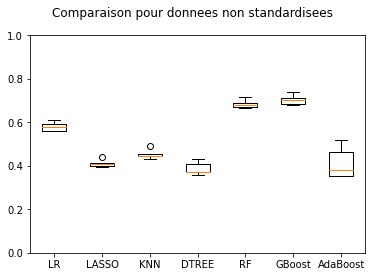

In [208]:
fig = plt.figure()
plt.ylim(0, 1)
fig.suptitle('Comparaison pour donnees non standardisees')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Pour les donnees standardisees

In [189]:
num_folds=5
results_std = []
names_std = []
model=LinearRegression()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, trainstd_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results_std.append(cv_results)
names_std.append("LR")

In [190]:
model=Lasso()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, trainstd_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results_std.append(cv_results)
names_std.append("Lasso")

In [191]:
model=KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, trainstd_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results_std.append(cv_results)
names_std.append("KNN")

In [192]:
model=DecisionTreeRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, trainstd_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results_std.append(cv_results)
names_std.append("DTREE")

In [193]:
model=RandomForestRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, trainstd_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results_std.append(cv_results)
names_std.append("RF")

In [194]:
model=GradientBoostingRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, trainstd_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results_std.append(cv_results)
names_std.append("GBoost")

In [195]:
model=AdaBoostRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, trainstd_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results_std.append(cv_results)
names_std.append("AdaBoost")

<ipython-input-212-bd77f69d0a04>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


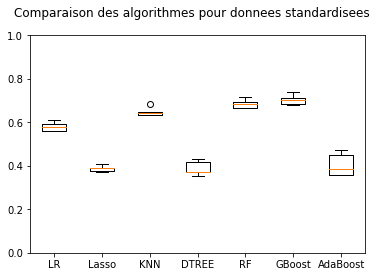

In [212]:
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes pour donnees standardisees')
plt.ylim(0, 1)
ax = fig.add_subplot(111)
plt.boxplot(results_std)
ax.set_xticklabels(names_std)
plt.show()

Pour les donnees nettoyees et standardisees

In [197]:
num_folds=5
results_c_std = []
names_c_std = []
model=LinearRegression()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, train_c_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results_c_std.append(cv_results)
names_c_std.append("LR")

In [198]:
model=Lasso()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, train_c_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results_c_std.append(cv_results)
names_c_std.append("Lasso")

In [199]:
model=KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, train_c_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results_c_std.append(cv_results)
names_c_std.append("KNN")

In [200]:
model=DecisionTreeRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, train_c_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results_c_std.append(cv_results)
names_c_std.append("DTREE")

In [201]:
model=RandomForestRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, train_c_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results_c_std.append(cv_results)
names_c_std.append("RF")

In [202]:
model=GradientBoostingRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, train_c_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results_c_std.append(cv_results)
names_c_std.append("GBoost")

In [203]:
model=AdaBoostRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_results = cross_val_score(model, train_c_x, train_y.values.ravel(), cv=kfold,scoring='r2')
results_c_std.append(cv_results)
names_c_std.append("AdaBoost")

<ipython-input-214-af9b73b4607a>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


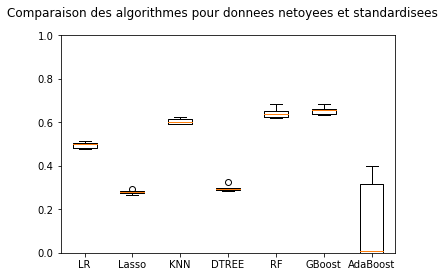

In [214]:
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes pour donnees netoyees et standardisees')
plt.ylim(0, 1)
ax = fig.add_subplot(111)
plt.boxplot(results_c_std)
ax.set_xticklabels(names_std)
plt.show()

On calcule maintenant les resultats pour les donnees de test

In [215]:
test_x=test.drop(['VendorID', 'store_and_fwd_flag'], axis=1)
test_x=test_x.dropna()
test_x['elapsed_time']=(test_x['tpep_dropoff_datetime']-test_x['tpep_pickup_datetime']).dt.total_seconds() / 60
test_x['pickup_hour'] = test_x['tpep_pickup_datetime'].dt.hour
test_x=test_x.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)
teststd_x=pd.DataFrame(scaler.fit_transform(test_x), columns=test_x.columns)

In [218]:
lin_regressor=LinearRegression()
lin_regressor.fit(train_x, train_y)
lin_prediction_train=pd.DataFrame(lin_regressor.predict(train_x), columns=['tip_amount'])

In [219]:
lin_prediction_train['tip_amount']=lin_prediction_train['tip_amount'].apply(lambda x: max(x, 0))
linscore = r2_score(train_y,lin_prediction_train)
linscore

0.6056189002521495

In [ ]:
lin_prediction_=lin_regressor.predict(teststd_x)
linreg_prediction = pd.DataFrame(lin_prediction, columns=['tip_amount'])

On applique notre fonction lambda, et on sauvegarde les donnees dans le bon format.

In [ ]:
linreg_prediction['tip_amount']=linreg_prediction['tip_amount'].apply(lambda x: max(x, 0))

In [ ]:
linreg_prediction['row_ID']=linreg_prediction.index

In [ ]:
linreg_prediction.to_parquet("/Users/Anna/Documents/Python/Supervise_data_challenge/linreg_prediction.parquet", engine='pyarrow', index=True)

On entraine maintenant le modele de forets aleatoires.

On evalue le temps necessaire pour entrainer un premier modele pour estimer combien de tests nous pouvons faire pour tester les hyperparametres.

In [220]:
rfr = RandomForestRegressor(n_estimators=50)
start_time=time.time()
rfr.fit(trainstd_x, trainstd_y.values.ravel())
end_time = time.time()
training_time = end_time - start_time
training_time

31.299495220184326

On commence par quelques evaluations pour estimer l'ordre de grandeur du nombre d'estimateurs necessaires

In [221]:
scores =[]
for k in range(1, 50):
    rfr = RandomForestRegressor(n_estimators=k)
    rfr.fit(trainstd_x, trainstd_y.values.ravel())
    rfr_pred = pd.DataFrame(rfr.predict(teststd_x), columns=['tip_amount'])
    rfr_pred['tip_amount']=rfr_pred['tip_amount'].apply(lambda x: max(x, 0))
    cv_results = cross_val_score(rfr, trainstd_x, train_y.values.ravel(), cv=kfold, scoring='r2')
    scores.append(cv_results)


KeyboardInterrupt: 

On visualise le nombre d'estimateurs par rapport au score R2, sur lequel nous serons evalues 

In [ ]:
plt.plot(range(1, 100), scores)
plt.xlabel('Value of n_estimators for Random Forest Regressor')
plt.ylabel('R2 score')


In [ ]:
On fait une recheche des parametres ideaux

In [222]:
rf_regressor= RandomForestRegressor()
param_grid = {
    'n_estimators' : [10, 20, 30],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}


grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')
grid_search.fit(trainstd_x, train_y.values.ravel())

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 20, 30]},
             scoring='r2', verbose=2)

In [223]:
grid_search.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 30}

In [224]:
rf_regressor = RandomForestRegressor(n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_depth=10)
rf_regressor.fit(trainstd_x, train_y.values.ravel())
pred_test_rf=rf_regressor.predict(teststd_x)
rf_prediction = pd.DataFrame(pred_test_rf, columns=['tip_amount'])
rf_prediction['row_ID']=rf_prediction.index
rf_prediction.to_parquet("/Users/Anna/Documents/Python/Supervise_data_challenge/rf_prediction.parquet", engine='pyarrow', index=True)

Le modele de gradient boosting

In [229]:
gb_regressor = GradientBoostingRegressor()
param_grid = {
    'n_estimators' : [10, 20, 30],
    'max_depth': [2, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')
grid_search.fit(trainstd_x, train_y.values.ravel())

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 20, 30]},
             scoring='r2', verbose=2)

In [230]:
grid_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 30}

In [231]:
gb_regressor = GradientBoostingRegressor(n_estimators=30, min_samples_split=5, min_samples_leaf=1, max_depth=5)
gb_regressor.fit(trainstd_x, train_y.values.ravel())
pred_test_gb=gb_regressor.predict(teststd_x)
gb_prediction = pd.DataFrame(pred_test_gb, columns=['tip_amount'])
gb_prediction['tip_amount']=gb_prediction['tip_amount'].apply(lambda x: max(x, 0))
gb_prediction['row_ID']=gb_prediction.index
gb_prediction.to_parquet("/Users/Anna/Documents/Python/Supervise_data_challenge/gb_prediction.parquet", engine='pyarrow', index=True)

Et KNN

In [233]:
knn_regressor=KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski']
}
grid_search = GridSearchCV(estimator=knn_regressor, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(trainstd_x, train_y.values.ravel())

GridSearchCV(cv=3, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [3, 5, 10, 15, 20],
                         'weights': ['uniform', 'distance']},
             scoring='r2')

In [234]:
grid_search.best_params_

{'metric': 'minkowski', 'n_neighbors': 20, 'weights': 'distance'}

In [ ]:
knn_regressor = KNeighborsRegressor(n_neighbors=20, metric='minkowski', weights='distance')
knn_regressor.fit(trainstd_x, train_y.values.ravel())
pred_test_knn=knn_regressor.predict(teststd_x)
knn_prediction = pd.DataFrame(pred_test_knn, columns=['tip_amount'])
knn_prediction['tip_amount']=knn_prediction['tip_amount'].apply(lambda x: max(x, 0))
knn_prediction['row_ID']=knn_prediction.index
knn_prediction.to_parquet("/Users/Anna/Documents/Python/Supervise_data_challenge/knn_prediction.parquet", engine='pyarrow', index=True)